# Data processing for bump hunt

Main differences for bump hunt:
- No fully supervised set
- test set covers the whole SR / SB range



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from helpers.plotting import *
from helpers.physics_functions import *
from helpers.data_transforms import *

plt.style.use("../science.mplstyle")


In [2]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)

In [3]:
project_id = "lowmass"
scaler_id = "logit_08_22"

working_dir = "/global/cfs/cdirs/m3246/rmastand/dimuonAD"
path_to_compiled_data = f"{working_dir}/compiled_data/{project_id}"
    
    
run_jet = False
if run_jet:
    codes_list = ["DATA_jet"]
    sim_id = "DATA_jet" # should probably rename this to data_id
else:
    codes_list = ["DATA_nojet"]
    sim_id = "DATA_nojet" # should probably rename this to data_id
signal_id = ""

    
uncut_data, uncut_data_samesign = {code:{} for code in codes_list},  {code:{} for code in codes_list}

for code in codes_list:
    with open(f"{path_to_compiled_data}/{code}", "rb") as ifile:
        tmp_dict = pickle.load(ifile)
        for key in tmp_dict.keys():
            if "samesign" in key:
                uncut_data_samesign[code][key[:-9]] = tmp_dict[key]
            else:
                uncut_data[code][key] = tmp_dict[key]
        
    
    print(code, "opp sign",  uncut_data[code][list(uncut_data[code].keys())[0]].shape)
    print(code, "same sign", uncut_data_samesign[code][list(uncut_data[code].keys())[0]].shape)

DATA_nojet opp sign (21803678,)
DATA_nojet same sign (6756613,)


## Visualize the data

In [4]:
feature_set = list(uncut_data[codes_list[0]].keys())
print(feature_set)

#hist_all_features_dict([uncut_data[codes_list[0]]], codes_list, feature_set, kwargs_dict_dtype, nice_labels=True)
    


['mu0_ip3d', 'mu1_ip3d', 'mu0_jetiso', 'mu1_jetiso', 'mu0_eta', 'mu1_eta', 'mu0_pt', 'mu1_pt', 'mu0_phi', 'mu1_phi', 'mu0_iso04', 'mu1_iso04', 'dimu_pt', 'dimu_eta', 'dimu_phi', 'n_muons', 'n_jets', 'dimu_mass', 'mumu_deltaR', 'mumu_deltapT']


## Make cuts

Now let's define cuts on the data. 

Muon cuts were made previously (and we don't want to make cuts on the dimuon system, either)

Random seed is used to set aside a portion of the test set

In [5]:
particle_type = "upsilon"
analysis_test = "iso" # iso, pt, none


if particle_type == "upsilon":    
    iso_cut = 0.55
    pt_cut = None
    if analysis_test == "iso":
        N_test = 30000
        random_seed = 22 # 2.78
        random_seed = 22 # 2.5


elif particle_type == "psi_prime":    
    pt_cut = None
    if analysis_test == "iso_low":
        iso_cut = 0.7
        N_test = 1000
        random_seed = 9 # 2.85
    elif analysis_test == "iso_high":
        iso_cut = 1.1
        N_test = 10000
        random_seed = 11 # 2.76    
        
if particle_type == "psi":
    iso_cut = 8
    pt_cut = None
    if analysis_test == "iso":
        N_test = 1000
        random_seed = 13 # 2.76
        
        
if particle_type == "rho":
    iso_cut = None
    pt_cut = 60
    if analysis_test == "pt":
        N_test = 3000
        random_seed = 12 # 2.78
    
elif particle_type == "eta":
    mass = 0.547
    iso_cut = 0
    pt_cut = None
    if analysis_test == "none":
        N_test = 40000
        random_seed = 4 # 2.82
    if analysis_test == "none_2" or analysis_test == "none_3":
        N_test = 150000
        random_seed = 4 # 2.82
    if analysis_test == "iso":
        N_test = 50000
        random_seed = 5 # 3.4

SB_left = float(workflow[particle_type]["SB_left"])
SR_left = float(workflow[particle_type]["SR_left"])
SR_right = float(workflow[particle_type]["SR_right"])
SB_right = float(workflow[particle_type]["SB_right"])


band_bounds = {"SBL": [SB_left,SR_left],
                   "SR": [SR_left,SR_right],
                   "SBH": [SR_right,SB_right],
                           }

    


plot_bins_SR = np.linspace(SR_left, SR_right, 6)
width = plot_bins_SR[1] - plot_bins_SR[0]


In [6]:
cut_data, cut_data_samesign = {code:{} for code in codes_list},  {code:{} for code in codes_list}

for code in codes_list:
    
    # define cuts to reduce the starting significance
    if "iso" in analysis_test:
        pass_indices = (uncut_data[code]["mu0_iso04"] >= iso_cut) & (uncut_data[code]["mu1_iso04"] >= iso_cut)
        pass_indices_samesign = (uncut_data_samesign[code]["mu0_iso04"] >= iso_cut) & (uncut_data_samesign[code]["mu1_iso04"] >= iso_cut)
        
    elif analysis_test == "pt":
        pass_indices = (uncut_data[code]["dimu_pt"] >= pt_cut)
        pass_indices_samesign = (uncut_data_samesign[code]["dimu_pt"] >= pt_cut)
        
    elif analysis_test == "none" or analysis_test == "none_2" or analysis_test == "none_3":
        pass_indices = (uncut_data[code]["dimu_pt"] >= -1)
        pass_indices_samesign = (uncut_data_samesign[code]["dimu_pt"] >= -1)
        
        
    
    # apply cuts to oppsign
    for feat in feature_set:
        cut_data[code][feat] = uncut_data[code][feat][pass_indices]
    # apply cuts to samesign
    for feat in feature_set:
        cut_data_samesign[code][feat] = uncut_data_samesign[code][feat][pass_indices_samesign]
    
    print(f"{code} oppsign has shape {cut_data[code][feat].shape} after cuts")
    print(f"{code} samesign has shape {cut_data_samesign[code][feat].shape} after cuts")
    
    
#hist_all_features_dict([cut_data["DATA_nojet"]], ["DATA_nojet"], feature_set, kwargs_dict_dtype, nice_labels=True)


DATA_nojet oppsign has shape (4936595,) after cuts
DATA_nojet samesign has shape (3285798,) after cuts


Check how local cuts affect the starting significance

(432859,)


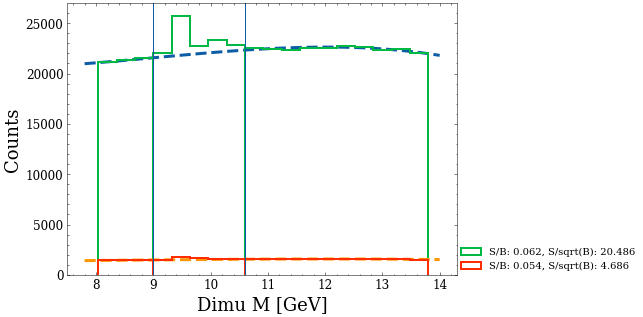

In [7]:
bkg_fit_type = "cubic"
bkg_fit_function = bkg_fit_cubic
plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR= 6)

x = np.linspace(SB_left, SB_right, 100) # plot curve fit

masses_with_bounds = cut_data[code]["dimu_mass"][(cut_data[code]["dimu_mass"] >= SB_left) & (cut_data[code]["dimu_mass"] <= SB_right)]
masses_with_bounds_samesign = cut_data_samesign[code]["dimu_mass"][(cut_data_samesign[code]["dimu_mass"] >= SB_left) & (cut_data_samesign[code]["dimu_mass"] <= SB_right)]


plt.figure(figsize = (7,5))

# plot all data
loc_data = masses_with_bounds
print(loc_data.shape)
popt_0, _, _, _, _ = curve_fit_m_inv(loc_data, bkg_fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all)

plt.plot(x, bkg_fit_function(x, *popt_0), lw = 3, linestyle = "dashed")
num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(loc_data, bkg_fit_function, plot_bins_SR, SR_left, SR_right, popt_0)

plt.hist(loc_data, bins = plot_bins_all, lw = 2, histtype = "step", density = False, label = f"S/B: {round(num_S_expected_in_SR/num_B_expected_in_SR,3)}, S/sqrt(B): {round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR),3)}")


# plot subset of data
np.random.shuffle(masses_with_bounds)
loc_data = masses_with_bounds[:N_test]
popt_0, _, _, _, _ = curve_fit_m_inv(loc_data, bkg_fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all)
plt.plot(x, bkg_fit_function(x, *popt_0), lw = 3, linestyle = "dashed")
num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(loc_data, bkg_fit_function, plot_bins_SR, SR_left, SR_right, popt_0)
plt.hist(loc_data, bins = plot_bins_all, lw = 2, histtype = "step", density = False, label = f"S/B: {round(num_S_expected_in_SR/num_B_expected_in_SR,3)}, S/sqrt(B): {round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR),3)}")


plt.axvline(SR_left)
plt.axvline(SR_right)

plt.xlabel("Dimu M [GeV]")
plt.ylabel("Counts")
plt.legend(loc = (1, 0))

#plt.yscale("log")

plt.show()

 
    
#hist_all_features(codes_list, cut_data, feature_set, kwargs_dict_dtype)


/global/homes/r/rmastand/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


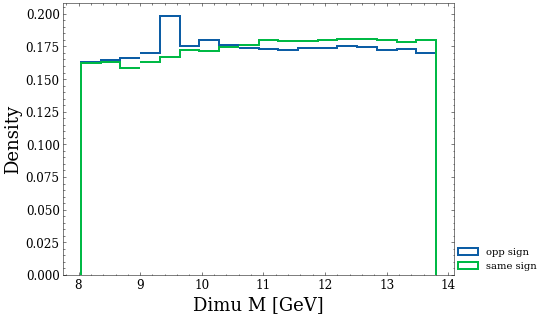

In [8]:

plt.figure(figsize = (7,5))

# plot all data
loc_data = masses_with_bounds
plt.hist(loc_data, bins = plot_bins_all, lw = 2, histtype = "step", density = True, label = f"opp sign")
plt.hist(masses_with_bounds_samesign, bins = plot_bins_all, lw = 2, histtype = "step", density = True, label = f"same sign")


plt.xlabel("Dimu M [GeV]")
plt.ylabel("Density")
plt.legend(loc = (1, 0))


plt.show()
 
    
#hist_all_features(codes_list, cut_data, feature_set, kwargs_dict_dtype)


Split data into bands

In [9]:
bands = ["SBL", "SR", "SBH"]
N_total_events = 0
N_total_events_samesign = 0



preproc_dicts, preproc_dicts_samesign = {b:{} for b in bands}, {b:{} for b in bands}


for code in codes_list:
    for b in bands:

        # opp sign
        loc_pass_indices = (cut_data[code]["dimu_mass"] >= band_bounds[b][0]) & (cut_data[code]["dimu_mass"] < band_bounds[b][1])
        preproc_dicts[b][code] = {}
        for feat in feature_set:
            preproc_dicts[b][code][feat] = cut_data[code][feat][loc_pass_indices]
            
       
        N_total_events += preproc_dicts[b][code][feat].shape[0]
        
        # same sign
        loc_pass_indices_samesign = (cut_data_samesign[code]["dimu_mass"] >= band_bounds[b][0]) & (cut_data_samesign[code]["dimu_mass"] < band_bounds[b][1])
        preproc_dicts_samesign[b][code] = {}
        for feat in feature_set:
            preproc_dicts_samesign[b][code][feat] = cut_data_samesign[code][feat][loc_pass_indices_samesign]
            
        N_total_events_samesign += preproc_dicts_samesign[b][code][feat].shape[0]
  
    
    
print(f"Total events opp sign: {N_total_events}")
print(f"Total events same sign: {N_total_events_samesign}")
    

Total events opp sign: 432859
Total events same sign: 332341


## Preprocessing

Standard scaling is fine

In [10]:
from sklearn.preprocessing import StandardScaler

sizes_dict, sizes_dict_samesign = {}, {}


proccessed_data_dict, proccessed_data_dict_samesign  = {b:{"s_inj_data":{}} for b in bands}, {b:{"s_inj_data":{}} for b in bands}

for feat in feature_set: 
    
    # train the preprocessor on the opp sign data only
    data_SB = np.hstack((preproc_dicts["SBL"][sim_id][feat], preproc_dicts["SBH"][sim_id][feat])).reshape(-1, 1)
    
    if feat == "dimu_mass": # don't logit transform
        mass_scaler = StandardScaler()
        mass_scaler = mass_scaler.fit(data_SB)
        
        with open(f"{working_dir}/projects/{scaler_id}/processed_data/mass_scaler_{particle_type}_{analysis_test}", "wb") as ofile:
            pickle.dump(mass_scaler, ofile)
            
        for b in bands:
            proccessed_data_dict[b]["s_inj_data"][feat] = mass_scaler.transform(preproc_dicts[b][sim_id][feat].reshape(-1,1))
            proccessed_data_dict_samesign[b]["s_inj_data"][feat] =  mass_scaler.transform(preproc_dicts_samesign[b][sim_id][feat].reshape(-1,1))
            sizes_dict[b] = proccessed_data_dict[b]["s_inj_data"][feat].shape[0]
            sizes_dict_samesign[b] = proccessed_data_dict_samesign[b]["s_inj_data"][feat].shape[0]
    
        
    else: 
        
        data_all = np.hstack((preproc_dicts["SBL"][sim_id][feat], preproc_dicts["SBH"][sim_id][feat], preproc_dicts["SR"][sim_id][feat])).reshape(-1, 1)
        all_min = np.min(data_all)
        all_max = np.max(data_all)
        # logit transform the features
    
        transformed_feats = logit_transform(data_SB, all_min, all_max)
        # subtract off mean, std of the training set
        mean_to_sub = np.mean(transformed_feats)
        std_to_sub = np.std(transformed_feats)

    
        for b in bands:
            proccessed_data_dict[b]["s_inj_data"][feat] = (logit_transform(preproc_dicts[b][sim_id][feat], all_min, all_max) - mean_to_sub)/std_to_sub
            proccessed_data_dict_samesign[b]["s_inj_data"][feat] = (logit_transform(preproc_dicts_samesign[b][sim_id][feat], all_min, all_max) - mean_to_sub)/std_to_sub


      

/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


In [11]:
print(sizes_dict)
print(sizes_dict_samesign)

{'SBL': 78048, 'SR': 116619, 'SBH': 238192}
{'SBL': 59285, 'SR': 84148, 'SBH': 188908}


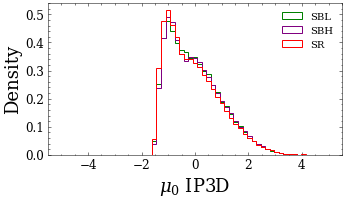

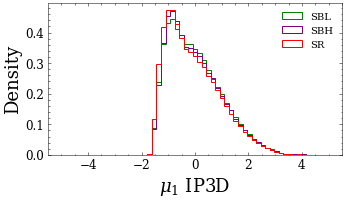

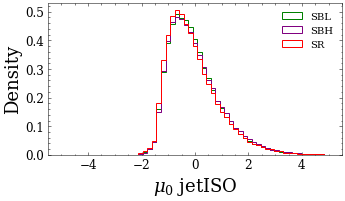

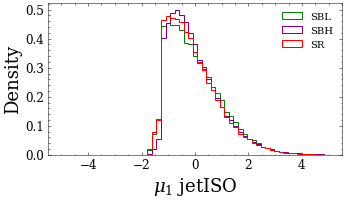

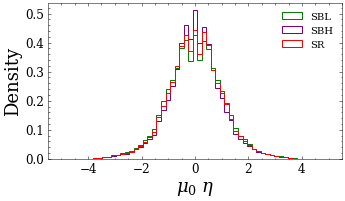

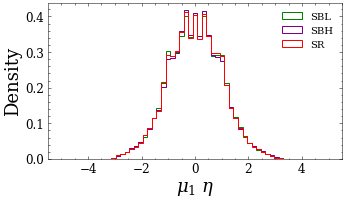

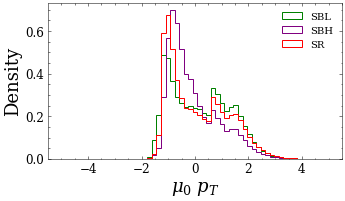

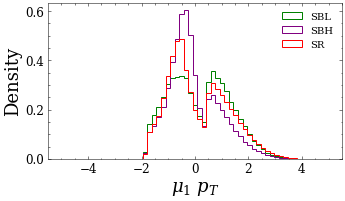

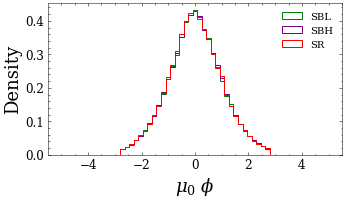

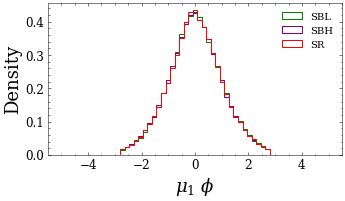

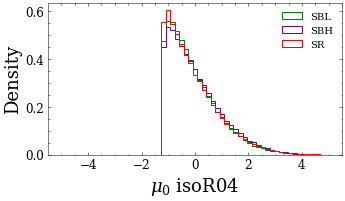

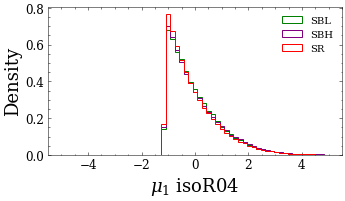

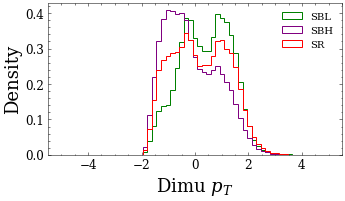

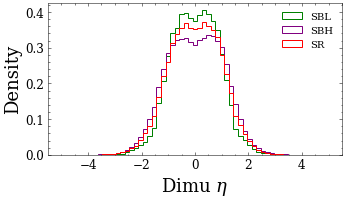

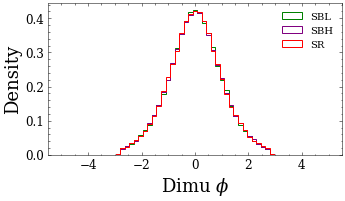

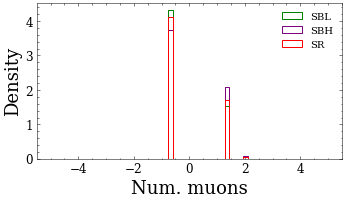

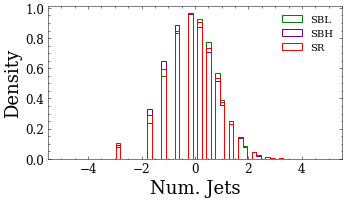

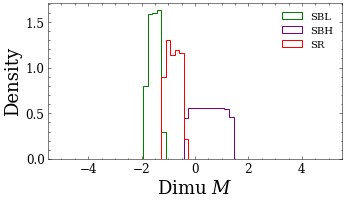

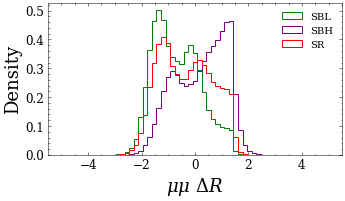

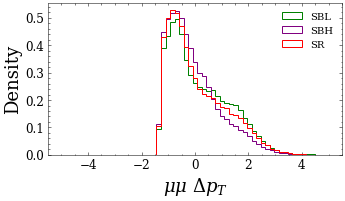

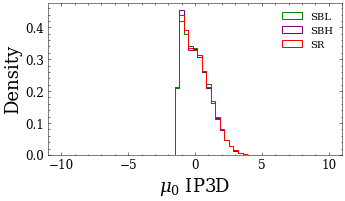

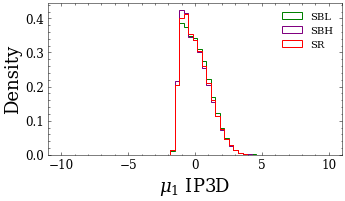

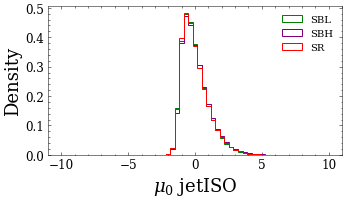

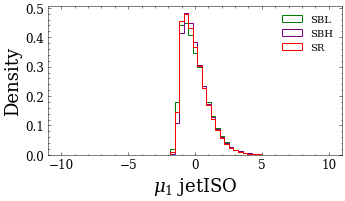

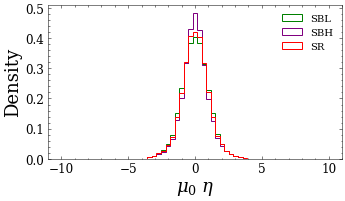

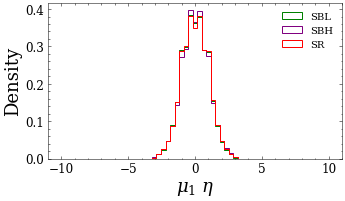

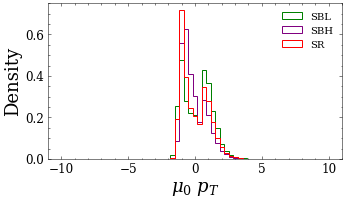

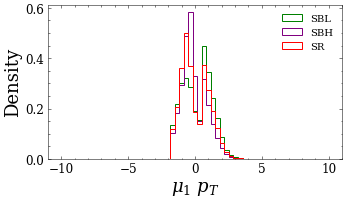

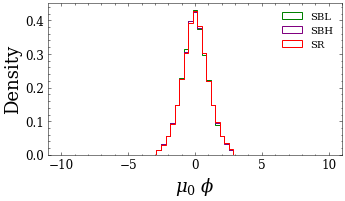

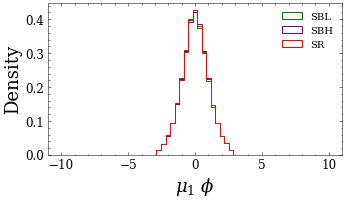

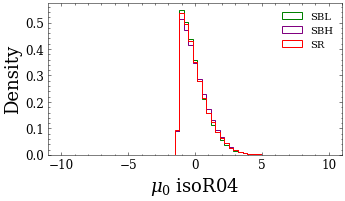

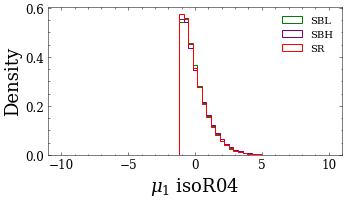

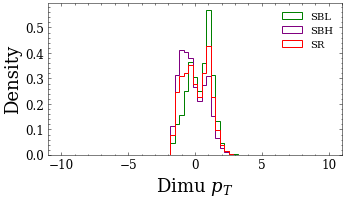

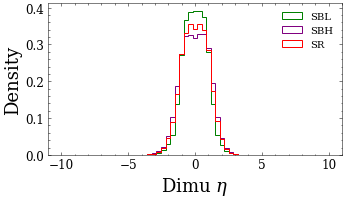

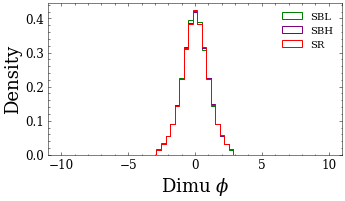

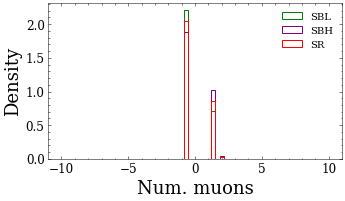

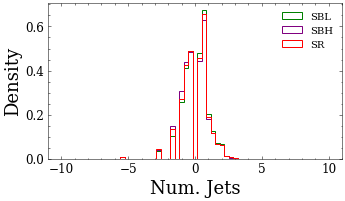

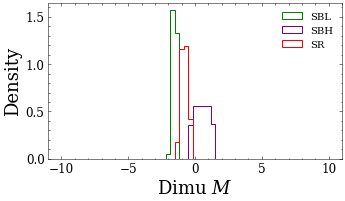

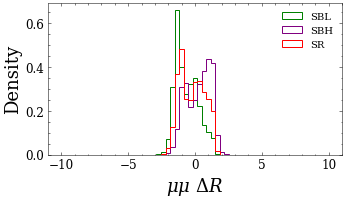

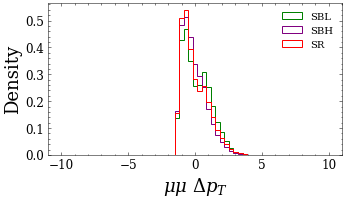

In [12]:
hist_all_features_dict([proccessed_data_dict["SBL"]["s_inj_data"], proccessed_data_dict["SBH"]["s_inj_data"], proccessed_data_dict["SR"]["s_inj_data"]], 
                       ["SBL", "SBH", "SR"], feature_set, kwargs_dict_bands, scaled_features=True, plot_bound=5, image_path=None, yscale_log=False, nice_labels=True)


hist_all_features_dict([proccessed_data_dict_samesign["SBL"]["s_inj_data"], proccessed_data_dict_samesign["SBH"]["s_inj_data"], proccessed_data_dict_samesign["SR"]["s_inj_data"]], 
                       ["SBL", "SBH", "SR"], feature_set, kwargs_dict_bands, scaled_features=True, plot_bound=10, image_path=None, yscale_log=False, nice_labels=True)





In [13]:
# specify a percentage of events to set aside for the test set


train_data_dict = {b:{"s_inj_data":{}} for b in bands}
test_data_dict = {b:{"s_inj_data":{}} for b in bands}

train_data_dict_samesign = {b:{"s_inj_data":{}} for b in bands}
test_data_dict_samesign = {b:{"s_inj_data":{}} for b in bands}


print(sizes_dict)

for b in bands:
    
    random_seed = 45

    # make sets for opp sign
    
    # get indices to select
    loc_num_test_events = int((N_test/N_total_events)*sizes_dict[b])
    
    np.random.seed(random_seed)
    test_set_inds = np.random.choice(range(sizes_dict[b]), size = loc_num_test_events, replace = False)
    train_set_inds = np.setdiff1d(list(range(sizes_dict[b])),test_set_inds)
        
    for feat in feature_set:
 
        train_data_dict[b]["s_inj_data"][feat] = proccessed_data_dict[b]["s_inj_data"][feat][train_set_inds]
        test_data_dict[b]["s_inj_data"][feat] = proccessed_data_dict[b]["s_inj_data"][feat][test_set_inds]
        
    # make sets for same sign
    if particle_type == "eta":
        loc_num_test_events_samesign = np.int((2000/N_total_events_samesign)*sizes_dict_samesign[b])
    elif particle_type == "rho":
        loc_num_test_events_samesign = np.int((10/N_total_events_samesign)*sizes_dict_samesign[b])
    else:
        loc_num_test_events_samesign = np.int((N_test/N_total_events_samesign)*sizes_dict_samesign[b])
    
    np.random.seed(random_seed)
    test_set_inds_samesign = np.random.choice(range(sizes_dict_samesign[b]), size = loc_num_test_events_samesign, replace = False)
    train_set_inds_samesign = np.setdiff1d(list(range(sizes_dict_samesign[b])),test_set_inds_samesign)
        
    for feat in feature_set:
 
        train_data_dict_samesign[b]["s_inj_data"][feat] = proccessed_data_dict_samesign[b]["s_inj_data"][feat][train_set_inds_samesign]
        test_data_dict_samesign[b]["s_inj_data"][feat] = proccessed_data_dict_samesign[b]["s_inj_data"][feat][test_set_inds_samesign]


test_set_size = test_data_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0] + test_data_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]+ test_data_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]
train_set_size = train_data_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0] + train_data_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]+ train_data_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]

test_set_size_samesign = test_data_dict_samesign["SR"]["s_inj_data"]["dimu_mass"].shape[0] + test_data_dict_samesign["SBL"]["s_inj_data"]["dimu_mass"].shape[0]+ test_data_dict_samesign["SBH"]["s_inj_data"]["dimu_mass"].shape[0]
train_set_size_samesign = train_data_dict_samesign["SR"]["s_inj_data"]["dimu_mass"].shape[0] + train_data_dict_samesign["SBL"]["s_inj_data"]["dimu_mass"].shape[0]+ train_data_dict_samesign["SBH"]["s_inj_data"]["dimu_mass"].shape[0]

print(f"{test_set_size} test events (target: {N_test}). {train_set_size} train events")    
print(f"{test_set_size_samesign} samesign test events (target: {N_test}). {train_set_size_samesign} samesign train events")      

{'SBL': 78048, 'SR': 116619, 'SBH': 238192}


/tmp/ipykernel_638577/4138950045.py:37: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  loc_num_test_events_samesign = np.int((N_test/N_total_events_samesign)*sizes_dict_samesign[b])


29999 test events (target: 30000). 402860 train events
29998 samesign test events (target: 30000). 302343 samesign train events


In [14]:
## trial_train_set = mass_scaler.inverse_transform(np.concatenate((train_data_dict["SBL"]["s_inj_data"]["dimu_mass"], train_data_dict["SBH"]["s_inj_data"]["dimu_mass"], train_data_dict["SR"]["s_inj_data"]["dimu_mass"])))
trial_test_set = mass_scaler.inverse_transform(np.concatenate((test_data_dict["SBL"]["s_inj_data"]["dimu_mass"], test_data_dict["SBH"]["s_inj_data"]["dimu_mass"], test_data_dict["SR"]["s_inj_data"]["dimu_mass"])))
#trial_test_set = mass_scaler.inverse_transform(np.concatenate((test_data_dict_samesign["SBL"]["s_inj_data"]["dimu_mass"], test_data_dict_samesign["SBH"]["s_inj_data"]["dimu_mass"], test_data_dict_samesign["SR"]["s_inj_data"]["dimu_mass"])))


354.3521759695368 7727.647824030463



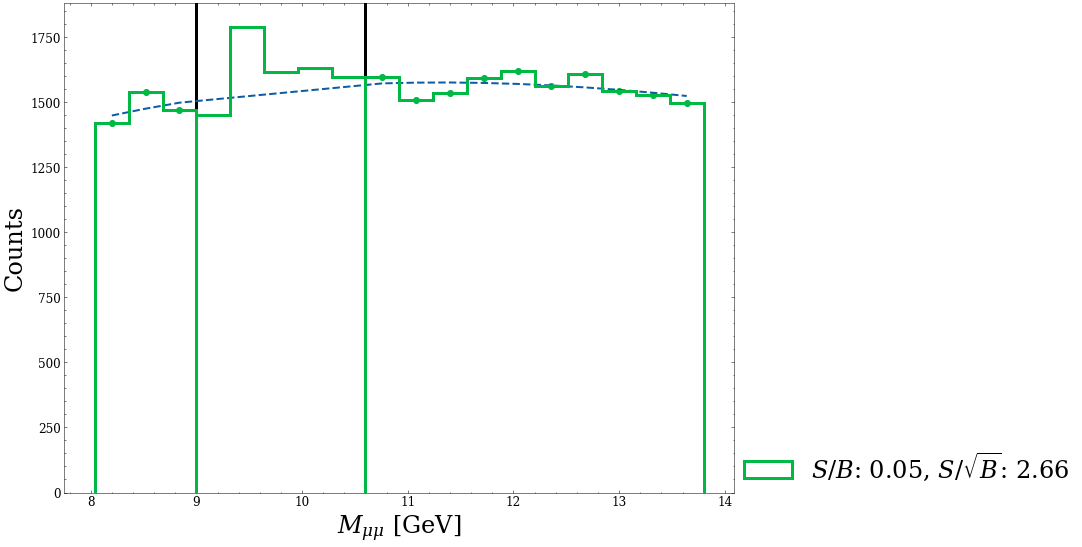

In [15]:

x = np.linspace(SB_left, SB_right, 100)

# get bins, bin centers
plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right)


fit_type = "ratio"
if fit_type == "cubic": fit_function = bkg_fit_cubic
elif fit_type == "quintic":nfit_function = bkg_fit_quintic
elif fit_type == "ratio": fit_function = bkg_fit_ratio

plt.figure(figsize = (12, 9))


# get the fit function to SB background
popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(trial_test_set, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all, SBL_rescale=None, SBH_rescale=None)
#print("chi2/dof:", chi2/n_dof)
# plot the fit function
plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed")    

# calculate significance of bump
num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(trial_test_set, fit_function, plot_bins_SR, SR_left, SR_right, popt)
print(num_S_expected_in_SR, num_B_expected_in_SR)

y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
B_error = np.sum(y_err)

label_string = "$S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))

plt.hist(trial_test_set, bins = plot_bins_all, lw = 3, histtype = "step",label = label_string)
plt.scatter(plot_centers_SB, y_vals)
    
    

print() 
plt.legend(loc = (1, 0), fontsize = 24)


plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
plt.ylabel("Counts", fontsize = 24)
plt.show()
    

In [16]:
if run_jet:
    with open(f"{working_dir}/projects/{scaler_id}/processed_data/{project_id}_{particle_type}_{analysis_test}_jet_train_band_data", "wb") as ofile:
        pickle.dump(train_data_dict, ofile)


    with open(f"{working_dir}/projects/{scaler_id}/processed_data/{project_id}_{particle_type}_{analysis_test}_jet_test_band_data", "wb") as ofile:
        pickle.dump(test_data_dict, ofile)



    with open(f"{working_dir}/projects/{scaler_id}/processed_data/{project_id}_{particle_type}_{analysis_test}_samesign_jet_train_band_data", "wb") as ofile:
        pickle.dump(train_data_dict_samesign, ofile)


    with open(f"{working_dir}/projects/{scaler_id}/processed_data/{project_id}_{particle_type}_{analysis_test}_samesign_jet_test_band_data", "wb") as ofile:
        pickle.dump(test_data_dict_samesign, ofile)

else:
    with open(f"{working_dir}/projects/{scaler_id}/processed_data/{project_id}_{particle_type}_{analysis_test}_nojet_train_band_data", "wb") as ofile:
        pickle.dump(train_data_dict, ofile)


    with open(f"{working_dir}/projects/{scaler_id}/processed_data/{project_id}_{particle_type}_{analysis_test}_nojet_test_band_data", "wb") as ofile:
        pickle.dump(test_data_dict, ofile)



    with open(f"{working_dir}/projects/{scaler_id}/processed_data/{project_id}_{particle_type}_{analysis_test}_samesign_nojet_train_band_data", "wb") as ofile:
        pickle.dump(train_data_dict_samesign, ofile)


    with open(f"{working_dir}/projects/{scaler_id}/processed_data/{project_id}_{particle_type}_{analysis_test}_samesign_nojet_test_band_data", "wb") as ofile:
        pickle.dump(test_data_dict_samesign, ofile)
